In [16]:
import requests
import logging
from datetime import datetime
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AutoRegResults
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

# Constants and assumptions

In [17]:
# general BC params
SLOTS_PER_EPOCH = 32
SECONDS_PER_SLOT = 12
MIN_PER_EPOCH_CHURN_LIMIT = 2**2
CHURN_LIMIT_QUOTIENT = 2**16 # (=65,536)
MIN_GENESIS_TIME = 1606824000 # (Dec 1, 2020, 12pm UTC)
EPOCHS_PER_YEAR = 82180
SECONDS_PER_YEAR = 31556952
# genesis
GENESIS_DATE = '2020-12-01'
GENESIS_VALIDATORSCOUNT = 21063
# altair fork Oct-27-2021 10:56:23 AM +UTC Epoch number: 74,240
ALTAIR_EPOCH = 74240
altair_multiplier = 0.989
# Lido fee
lido_fee = 0.1
# Priority fee
priority_fee_monthly  = 22275.39743667664 # https://dune.xyz/queries/382535 (query date: 2022-04-06 11:00 UTC)
# MEV (Flashbots data)
avg_mev_reward_per_block = 0.185 # inferring from flashbots activity, we obtain this number by substracting the Flashbots miner tip from the tail gas price multiplied by the gas used by the mined Flashbots bundle.
lower_bound_for_active_staked_eth = 524288 # required for ETH2 to start
block_selection_frequency_flashbots = 58 # % of blocks seen by Flashbots-enabled miners contains Flashbots bundles


# Dataset preparing

## Functions for dataset preparing

In [18]:
def get_epoch_data(epoch="latest"):
    try:
        req = requests.get(f"https://beaconcha.in/api/v1/epoch/{epoch}", headers={"accept":"application/json"})
        req.raise_for_status()
        return req.json()["data"]
    except requests.exceptions.HTTPError as err:
        logging.error(err)
        return {}

def get_latest_epoch():
    return get_epoch_data()['epoch']

def get_epochs(start_epoch, end_epoch, epoch_interval):
    epochs_list = []
    max_iteration = 19
    iteration = 0
    current_stat_epoch = start_epoch
    current_end_epoch = min(start_epoch + max_iteration*epoch_interval, end_epoch)
    while current_end_epoch < end_epoch or current_stat_epoch < end_epoch:
        if current_end_epoch < end_epoch:
            epochs_list.append([x for x in range(current_stat_epoch, current_end_epoch, int(epoch_interval))])
        else: 
            epochs_list.append([x for x in range(current_stat_epoch, end_epoch, int(epoch_interval))])
        iteration += 1
        current_stat_epoch = (start_epoch + iteration*max_iteration*epoch_interval)        
        current_end_epoch = (current_stat_epoch + max_iteration*epoch_interval)
        
    return epochs_list

def get_validatorscount(epochs):  
    return [get_epoch_data(x)['validatorscount'] for x in epochs]

def get_df(start_epoch, end_epoch, epoch_interval):
    epochs_list = get_epochs(start_epoch, end_epoch, epoch_interval)
    validatorscountdyn=[]
    epochs = []
    for iter in epochs_list:
        validatorscountdyn += get_validatorscount(iter)
        epochs += iter
        if  iter != epochs_list[-1]: time.sleep(60)
    return pd.DataFrame({'epoch': epochs, 'validatorscount': validatorscountdyn}).set_index('epoch')

def get_df_validatorscount(file_name, epoch_interval, start_epoch, is_dataset_new, is_dataset_needs_updates):
    if is_dataset_needs_updates:
        end_epoch = get_latest_epoch()
        if is_dataset_new: 
            df = get_df(start_epoch, end_epoch, epoch_interval)
        else: 
            df = pd.read_csv(file_name, sep = ",", index_col=['epoch'])
            start_epoch_ = max(df.index)+epoch_interval
            df = pd.concat([df, get_df(start_epoch_, end_epoch, epoch_interval)])
        df.to_csv(file_name, sep=',', encoding='utf-8', index=True)

def annualised_base_reward(validatorscount):
    return EPOCHS_PER_YEAR * 512 / math.sqrt(validatorscount * 32e9) # assuming all validators have an effective balance of 32 ETH

def average_blocks_proposed_per_year(validatorscount): 
    return SECONDS_PER_YEAR / (SECONDS_PER_SLOT * validatorscount) 

def get_current_entry_queue():
    return requests.get(f'https://beaconcha.in/api/v1/validators/queue', headers={"accept":"application/json"}).json()['data']['beaconchain_entering']

def get_validators_on_the_network_today():
    return get_epoch_data(epoch="latest")['validatorscount']

def get_altair_validatorscount():
    return requests.get(f"https://beaconcha.in/api/v1/epoch/{ALTAIR_EPOCH}", headers={"accept":"application/json"}).json()['data']['validatorscount']

## Preparing dataset of validatorscount

Period that is taken for modeling: 2021-09-19 00:00:00 - 2022-05-16 00:00:00
Entry queue in March 2022 is due to launching 2022-02-23 Aave<>Lido


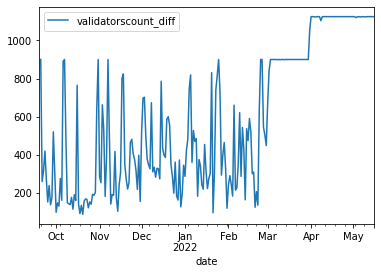

In [19]:
start_epoch = 65812 #2021-09-19
epoch_per_day = int(24*3600/(SLOTS_PER_EPOCH * SECONDS_PER_SLOT))
file_name = 'validatorscount.csv'
is_dataset_new = False
is_dataset_needs_updates = False
get_df_validatorscount(file_name, epoch_per_day, start_epoch, is_dataset_new, is_dataset_needs_updates)
# df_validatorscount - dataset for modeling (since 2021-09-19 till now)
df_validatorscount_for_forecast = pd.read_csv('validatorscount.csv', sep = ",", index_col=['epoch'])
df_validatorscount_for_forecast['date'] = [datetime.utcfromtimestamp(MIN_GENESIS_TIME+x*SLOTS_PER_EPOCH * SECONDS_PER_SLOT).strftime('%Y-%m-%d') for x in df_validatorscount_for_forecast.index]
df_validatorscount_for_forecast.to_csv(f'df_validatorscount.csv', sep=',', encoding='utf-8', index=True)
df_validatorscount_for_forecast = pd.read_csv('df_validatorscount.csv', sep = ",",index_col=['date'], parse_dates=['date'])[['epoch', 'validatorscount']]
print(f"Period that is taken for modeling: {df_validatorscount_for_forecast.index[0]} - {df_validatorscount_for_forecast.index[-1]}")
# df_validatorscountall - dataset from the begining of BC till now
df_validatorscount_actual = pd.concat([pd.read_csv('df_validatorscount_p1.csv', sep = ",",index_col=['date'], parse_dates=['date'])[['epoch', 'validatorscount']], df_validatorscount_for_forecast])
validatorscount_prealtair = df_validatorscount_actual.query('epoch<@ALTAIR_EPOCH').validatorscount.values
validatorscount_altair_actual = df_validatorscount_actual.query('epoch>=@ALTAIR_EPOCH').validatorscount.values
df_validatorscount_for_forecast['validatorscount_diff'] = df_validatorscount_for_forecast['validatorscount'].diff()
df_validatorscount_for_forecast[['validatorscount_diff']].plot()
print("Entry queue in March 2022 is due to launching 2022-02-23 Aave<>Lido")
df_validatorscount_for_forecast_1 = df_validatorscount_for_forecast[df_validatorscount_for_forecast.index<pd.Timestamp('2022-02-23')][['epoch', 'validatorscount']]
df_validatorscount_for_forecast_2 = df_validatorscount_for_forecast[df_validatorscount_for_forecast.index>=pd.Timestamp('2022-02-23')][['epoch', 'validatorscount']]

# Modeling BC dynamics pre- and post-Merge

## Functions for modeling BC dynamics pre- and post-Merge

In [20]:
# fit an AR model and save the whole model to file
def AR_model(series):
    def difference(dataset):
        diff = []
        for i in range(1, len(dataset)):
            value = dataset[i] - dataset[i - 1]
            diff.append(value)
        return np.array(diff)
    X = difference(series.values)
    # fit model
    model = AutoReg(X, lags=6)
    model_fit = model.fit()
    coef = model_fit.params
    # save the model, the differenced dataset and the last ob to the files
    model_fit.save('ar_model.pkl')
    np.save('ar_data.npy', X)
    np.save('ar_obs.npy', [series.values[-1]])

def add_observation(observation):   
    # load the saved data
    model = AutoRegResults.load('ar_model.pkl')
    data = np.load('ar_data.npy')
    last_ob = np.load('ar_obs.npy')
    # update and save differenced observation
    diffed = observation - last_ob[0]
    data = np.append(data, [diffed], axis=0)
    model = AutoReg(data, lags=6)
    model_fit = model.fit()
    model_fit.save('ar_model.pkl')
    np.save('ar_data.npy', data)
    # update and save real observation
    last_ob[0] = observation
    np.save('ar_obs.npy', last_ob)
    
def add_observation_model_const(observation):   
    # load the saved data
    model = AutoRegResults.load('ar_model.pkl')
    data = np.load('ar_data.npy')
    last_ob = np.load('ar_obs.npy')
    diffed = observation - last_ob[0]
    data = np.append(data, [diffed], axis=0)
    np.save('ar_data.npy', data)
    # update and save real observation
    last_ob[0] = observation
    np.save('ar_obs.npy', last_ob)

def get_forecast():
    # load model
    model = AutoRegResults.load('ar_model.pkl')
    data = np.load('ar_data.npy')
    last_ob = np.load('ar_obs.npy')
    # make prediction
    predictions = model.predict(start=len(data), end=len(data))
    # transform prediction
    yhat = predictions[0] + last_ob[0]
    return yhat

def forecast_diff(last_ob, last_date, forcast_period, model_update,columns):
    forcast_date = last_date + pd.to_timedelta(str(forcast_period) + ' day')
    forcast_dir = {}  
    while last_date<forcast_date:       
        if model_update: add_observation(last_ob)
        else: add_observation_model_const(last_ob)           
        last_ob = max(0,get_forecast())
        last_date +=pd.to_timedelta('1 day')
        forcast_dir.update({last_date:last_ob})
        #print(last_date,last_ob)       
    return pd.DataFrame(pd.Series(forcast_dir), columns = columns)

def forecast_validatorscount(last_validatorscount, last_date, df_forecast_diff,columns):   
    validatorscount_dic = {}       
    for i in df_forecast_diff:
        last_validatorscount = (i+1)*last_validatorscount
        last_date += pd.to_timedelta('1 day')
        validatorscount_dic.update({last_date:int(last_validatorscount)})      
    return pd.DataFrame(pd.Series(validatorscount_dic), columns = columns)

def final_forecast(df_forecast_validatorscount, df, show_results = False):   
    df_forecasted = pd.concat([df, df_forecast_validatorscount])
    if show_results:
        display(df_forecasted.tail())  
        fig, ax = plt.subplots(figsize=(20, 8))
        ax.plot(df.index.values, df.validatorscount.values, label="No of validators")
        ax.plot(df_forecast_validatorscount.index.values, df_forecast_validatorscount.validatorscount.values, linestyle="dotted", label="No of validators forecasted")
        ax.set_xlabel('Date')
        ax.set_ylabel('No of validators on the network')
        ax.set_title('Validators (forecast before Merge)')
        ax.legend()
        plt.show()   
    return df_forecasted
def current_entry_queue_blow_down(validators_per_epoch_forecasted, df_validatorscount_for_forecast_2):
    current_entry_queue = get_current_entry_queue()
    validators_on_the_network_today = get_validators_on_the_network_today()
    if int(current_entry_queue/(validators_on_the_network_today//CHURN_LIMIT_QUOTIENT - validators_per_epoch_forecasted)/epoch_per_day) > 1:
        df_validatorscount_for_forecast_2_ = df_validatorscount_for_forecast_2.copy()
        for x in range (int(current_entry_queue/(validators_on_the_network_today//CHURN_LIMIT_QUOTIENT - validators_per_epoch_forecasted)/epoch_per_day)):
            df_validatorscount_for_forecast_2_.loc[df_validatorscount_for_forecast_2_.index[-1] + pd.to_timedelta('1 day')] = [
                df_validatorscount_for_forecast_2_.epoch[-1]+epoch_per_day, 
                df_validatorscount_for_forecast_2_.validatorscount[-1] + int(df_validatorscount_for_forecast_2_.validatorscount[-1]//CHURN_LIMIT_QUOTIENT*epoch_per_day)]
    return df_validatorscount_for_forecast_2_

def get_df(first_date, periods, first_epoch):
    dates = pd.date_range(start=first_date, periods=periods)
    epochs = [x for x in range(first_epoch, first_epoch + epoch_per_day*periods, epoch_per_day)]
    return pd.DataFrame(data = {'epoch': epochs}, index = dates)

def forecast_using_AR_model(merge_date, df_validatorscount_for_forecast_1, df_validatorscount_for_forecast_2, df_validatorscount_actual, model_update = True, show_results = False):
    dataset = df_validatorscount_for_forecast_1.copy()
    dataset['validatorscount_diff'] = dataset.validatorscount.rolling(2).apply(lambda x: x[-1]/x[0]-1, raw=True)
    series = dataset.validatorscount_diff[1:]
    forcast_period = (pd.Timestamp(merge_date) - series.index[-1]).days-1
    last_ob = series.values[-1]
    last_date = series.index[-1]
    last_epoch = dataset.epoch[-1]
    last_validatorscount = dataset.validatorscount[-1]
    columns_diff = ['validatorscount_diff']
    columns_validatorscount = ['validatorscount']
    AR_model(series)
    df_forecast_diff = forecast_diff(last_ob, last_date, forcast_period, model_update, columns_diff) #forecast differences
    df_validatorscount_altair_forecast_AR = forecast_validatorscount(last_validatorscount, last_date, df_forecast_diff.validatorscount_diff, columns_validatorscount) #forecast validatorscounts
    df_validatorscount_altair_forecast_AR['epoch'] = [x for x in range(last_epoch+epoch_per_day,last_epoch+epoch_per_day*(forcast_period+1), epoch_per_day)]
    validators_per_epoch_forecasted_AR = (
        df_validatorscount_altair_forecast_AR.validatorscount[-1]-df_validatorscount_altair_forecast_AR.validatorscount[1])/(df_validatorscount_altair_forecast_AR
        .epoch[-1]-df_validatorscount_altair_forecast_AR.epoch[1]) # Validators per epoch forecasted
    df_validatorscount_for_forecast_2_AR = current_entry_queue_blow_down(validators_per_epoch_forecasted_AR, df_validatorscount_for_forecast_2) # modeling blowing down the existing entry queue
    validatorscount_delta = df_validatorscount_for_forecast_2_AR.validatorscount[-1] - df_validatorscount_altair_forecast_AR.at[pd.Timestamp(df_validatorscount_for_forecast_2_AR.index[-1]), 'validatorscount']
    df_validatorscount_altair_forecast_AR.validatorscount = np.concatenate([
        df_validatorscount_for_forecast_2_AR.validatorscount.values,
        df_validatorscount_altair_forecast_AR[df_validatorscount_altair_forecast_AR.index > df_validatorscount_for_forecast_2_AR.index[-1]].validatorscount.values + validatorscount_delta
    ])
    df_validatorscount_altair_forecast_AR = df_validatorscount_altair_forecast_AR[df_validatorscount_altair_forecast_AR.index>df_validatorscount_actual.index[-1]]
   # validatorscount_altair_forecast_AR = df_validatorscount_altair_forecast_AR.validatorscount.values
    df_validatorscount_before_merge_AR = final_forecast(df_validatorscount_altair_forecast_AR, df_validatorscount_actual, show_results)
    validatorscount_altair_AR = df_validatorscount_before_merge_AR.query('epoch>=@ALTAIR_EPOCH').validatorscount.values
    return [df_validatorscount_altair_forecast_AR, validatorscount_altair_AR]

def forecast_using_linear_model(merge_date, df_validatorscount_for_forecast_1, df_validatorscount_for_forecast_2, df_validatorscount_actual, show_results = False):
  #  validators_on_the_network_today = get_validators_on_the_network_today()
    validators_per_epoch_linear = (df_validatorscount_for_forecast_1.validatorscount[-1]-df_validatorscount_for_forecast_1.validatorscount[1])/(df_validatorscount_for_forecast_1.epoch[-1]-df_validatorscount_for_forecast_1.epoch[1])
    df_validatorscount_for_forecast_2_linear = current_entry_queue_blow_down(validators_per_epoch_linear, df_validatorscount_for_forecast_2) # modeling blowing down the existing entry queue
    validatorscount_altair_forecast_linear = np.concatenate(
        [df_validatorscount_for_forecast_2_linear[df_validatorscount_for_forecast_2_linear.index>df_validatorscount_actual.index[-1]].validatorscount.values,
        [x for x in range(
        int(df_validatorscount_for_forecast_2_linear.validatorscount[-1]) + int(validators_per_epoch_linear*epoch_per_day), 
        int(df_validatorscount_for_forecast_2_linear.validatorscount[-1]) + int(validators_per_epoch_linear*epoch_per_day)*((pd.Timestamp(merge_date) - df_validatorscount_for_forecast_2_linear.index[-1]).days-1)+1, 
        int(validators_per_epoch_linear*epoch_per_day)
        )]
        ])
    df_validatorscount_altair_forecast_linear = get_df(df_validatorscount_actual.index[-1] + pd.to_timedelta('1 day'), len(validatorscount_altair_forecast_linear), df_validatorscount_actual.epoch[-1] + epoch_per_day)
    df_validatorscount_altair_forecast_linear['validatorscount'] = validatorscount_altair_forecast_linear
    df_validatorscount_before_merge_linear = final_forecast(df_validatorscount_altair_forecast_linear, df_validatorscount_actual, show_results)
    validatorscount_altair_linear = df_validatorscount_before_merge_linear.query('epoch>=@ALTAIR_EPOCH').validatorscount.values
    return [df_validatorscount_altair_forecast_linear, validatorscount_altair_linear]

def forecast_based_on_levereged_staking(merge_date, df_validatorscount_for_forecast_2, df_validatorscount_actual, show_results = False): #Forcast based on levereged staking (= entry queue till the Merge date)
    validatorscount_altair_forecast_levstaking = [x for x in range(
        int(df_validatorscount_for_forecast_2.validatorscount[-1])+int(df_validatorscount_for_forecast_2.validatorscount[-1]//CHURN_LIMIT_QUOTIENT*epoch_per_day), 
        int(df_validatorscount_for_forecast_2.validatorscount[-1]) + int(df_validatorscount_for_forecast_2.validatorscount[-1]//CHURN_LIMIT_QUOTIENT*epoch_per_day)*((pd.Timestamp(merge_date) - df_validatorscount_for_forecast_2.index[-1]).days-1)+1, 
        int(df_validatorscount_for_forecast_2.validatorscount[-1]//CHURN_LIMIT_QUOTIENT*epoch_per_day)
        )]
    df_validatorscount_altair_forecast_levstaking = get_df(df_validatorscount_actual.index[-1] + pd.to_timedelta('1 day'), len(validatorscount_altair_forecast_levstaking), df_validatorscount_actual.epoch[-1] + epoch_per_day)
    df_validatorscount_altair_forecast_levstaking['validatorscount'] = validatorscount_altair_forecast_levstaking
    df_validatorscount_before_merge_levstaking = final_forecast(df_validatorscount_altair_forecast_levstaking, df_validatorscount_actual, show_results)
    validatorscount_altair_levstaking = df_validatorscount_before_merge_levstaking.query('epoch>=@ALTAIR_EPOCH').validatorscount.values
    return [df_validatorscount_altair_forecast_levstaking, validatorscount_altair_levstaking]

def get_df_bc_lido_actual():

    df = pd.read_csv('eth2_deposits.csv', sep = ",",index_col=['date'], parse_dates=['date'])#[:df_validatorscount_altair_forecast.index[0]-pd.Timedelta('1 day')]
    df['deposits'] = df.eth_amount//32
    df['lido_deposits'] = df.lido_amount//32
    df['eth_amount_cumsum'] = df.eth_amount.cumsum()
    df['lido_amount_cumsum'] = df.lido_amount.cumsum()
    df['lido_share_daily'] = df.lido_amount/df.eth_amount
    df['lido_share'] = df.lido_amount_cumsum/df.eth_amount_cumsum
    df = pd.merge(df, df_validatorscount_actual, left_index=True, right_index=True, how='left').fillna(0)
    df['eth_staked'] = df.validatorscount*32
    df['lido_staked'] = df['eth_staked']*df.lido_share

    return df[['validatorscount', 'eth_staked', 'eth_amount', 'lido_share_daily', 'lido_amount', 'lido_staked', 'lido_share']]
    

def get_df_bc_lido_forecasted(df_bc_lido_actual, df_validatorscount_altair_forecast, validatorscount_altair, eth_amount_before_merge_date, eth_amount_after_merge_date, lido_amount_share_forecast, new_validators_per_epoch, k, period, APR_periods):
    last_validatorscount = df_bc_lido_actual.validatorscount[-1]
    last_lido_staked = df_bc_lido_actual.lido_staked[-1]
    if len(eth_amount_before_merge_date) > len(df_validatorscount_altair_forecast): 
        print("The entry queue size before the Merge does not suit the expected Merge date")
    else:
        df = df_validatorscount_altair_forecast[['validatorscount']].head(-len(eth_amount_before_merge_date)).copy()
        df['eth_staked'] = df.validatorscount*32
        df['eth_amount'] = (df.validatorscount*32-df.validatorscount.shift(1)*32).fillna(df.validatorscount*32 - last_validatorscount*32)
        entry_queue_eth = 0
        for x in np.concatenate((eth_amount_before_merge_date, eth_amount_after_merge_date)):
            entry_queue_eth += x
            new_validators = min(entry_queue_eth//32, epoch_per_day * (df.validatorscount[-1]//CHURN_LIMIT_QUOTIENT))
            validatorscount = df.validatorscount[-1] + new_validators
            df.loc[df.index[-1] + pd.to_timedelta('1 day')] = [validatorscount, validatorscount*32, x]
            entry_queue_eth -=new_validators*32#entry_queue_eth
        
        for x in range(365+period - len(eth_amount_after_merge_date)+1):
            validatorscount = df.validatorscount[-1] + epoch_per_day * max(min(new_validators_per_epoch,df.validatorscount[-1]//CHURN_LIMIT_QUOTIENT),k*df.validatorscount[-1]//CHURN_LIMIT_QUOTIENT)
            df.loc[df.index[-1] + pd.to_timedelta('1 day')] = [validatorscount, validatorscount*32, validatorscount*32-df.validatorscount[-1]*32]
            
        df['lido_share_daily'] = lido_amount_share_forecast + lido_amount_share_forecast[-1:]*365
        df['lido_amount'] = df.eth_amount*df.lido_share_daily
        df['lido_staked'] = ((df.eth_staked-df.eth_staked.shift(1))*df.lido_share_daily).fillna(df.lido_amount).cumsum() + last_lido_staked
        df['lido_share'] = df.lido_staked/df.eth_staked

        df = pd.concat([df_bc_lido_actual,df])
    
        ideal_reward = np.concatenate([
        [0]*(pd.Timestamp(GENESIS_DATE) - df.index[0]).days,
        [(4 * annualised_base_reward(n)) for n in validatorscount_prealtair],
        [(4 * annualised_base_reward(n)*altair_multiplier) for n in validatorscount_altair],
        [(4 * annualised_base_reward(n)*altair_multiplier +  (avg_mev_reward_per_block * average_blocks_proposed_per_year(n)  * (block_selection_frequency_flashbots/100))+priority_fee_monthly*12/n) for n in df.loc[df_validatorscount_altair_forecast.index[-1]+pd.Timedelta('1 day'):].validatorscount.values]
        ])
        

        df['APR'] = [100 * r / 32 for r in ideal_reward]   # Validators' APR

        df['new_validators']=(df.validatorscount - df.validatorscount.shift(1)).fillna(df.validatorscount)

        df['daily_limit'] = (
            (df.validatorscount//CHURN_LIMIT_QUOTIENT)
            .where(df.validatorscount//CHURN_LIMIT_QUOTIENT > MIN_PER_EPOCH_CHURN_LIMIT, MIN_PER_EPOCH_CHURN_LIMIT)*epoch_per_day).where(df.index>pd.Timestamp(GENESIS_DATE),0)
        df.at[pd.Timestamp(GENESIS_DATE), 'daily_limit'] = df.at[pd.Timestamp(GENESIS_DATE),'new_validators']

        entry_queue = [0]
        for i in range(len(df)):
            if entry_queue[-1] + (df.eth_amount[i]//32 - df.daily_limit[i])*32 > 0:
                entry_queue.append(entry_queue[-1] + (df.eth_amount[i]//32 - df.daily_limit[i])*32)
            else: entry_queue.append(0)

        df['entry_queue'] = entry_queue[1:]
        df['lido_entry_queue'] = df.entry_queue*df.lido_share_daily


        df['entry_queue_days'] = (
            (pd.Timestamp(GENESIS_DATE) - df.index).days 
            + (df.entry_queue/32//GENESIS_VALIDATORSCOUNT)*((df.entry_queue//32-GENESIS_VALIDATORSCOUNT)//900+1)).where(
                df.index<pd.Timestamp(GENESIS_DATE), (df.entry_queue/32//df.daily_limit.shift(-1).fillna(df.daily_limit))
            ).astype(int)

        # moment APR for Lido stakers (Validators' APR - Lido's fee)
        df['APR_lido_pool'] = df.APR*df.lido_staked/(df.lido_staked + df.lido_entry_queue)*(1-lido_fee) # staked + entry queue
        df['APR_lido_staked'] = df.APR*(1-lido_fee)
        df['APR_lido_entry_queue'] = [df.loc[df.index[i+x], 'APR']*(1-lido_fee) if i+x < len(df) else df.loc[df.index[-1], 'APR']*(1-lido_fee) for i, x in enumerate(df.entry_queue_days)]

        # actual APR
        for period in APR_periods:
            # Validators' APR
            df[f'APR_actual_entry_queue_{period}'] = ([df.APR[i + min(queue_days, period): period + i].sum()/period for i, queue_days in enumerate([day for day in df.entry_queue_days])])
            df[f'APR_actual_staked_{period}'] = ([df.APR[i : period + i].sum()/period for i, queue_days in enumerate([day for day in df.entry_queue_days])])

            # APR for Lido stakers (Validators' APR - Lido's fee)
            df[f'APR_actual_lido_staked_{period}'] = df[f'APR_actual_staked_{period}']*(1-lido_fee)
            df[f'APR_actual_lido_entry_queue_{period}'] = df[f'APR_actual_entry_queue_{period}']*(1-lido_fee)
            df[f'APR_actual_lido_pool_{period}'] = ((df.lido_staked*df[f'APR_actual_lido_staked_{period}'] + df.lido_entry_queue*df[f'APR_actual_lido_entry_queue_{period}'])/(df.lido_staked + df.lido_entry_queue)).where(df.lido_staked>0,0)
            

            # APR loss for stakers and extra APR for entry queue
            df[f'APR_lido_staked_loss_{period}'] = df[f'APR_actual_lido_staked_{period}'] - df[f'APR_actual_lido_pool_{period}']
            df[f'APR_lido_staked_loss_{period}_%'] = df[f'APR_lido_staked_loss_{period}']/df[f'APR_actual_lido_staked_{period}']*100
            df[f'APR_lido_entry_queue_extra_{period}'] = df[f'APR_actual_lido_pool_{period}'] - df[f'APR_actual_lido_entry_queue_{period}']

            #rewards 
            df[f'rewards_lido_pool_per_1k_{period}'] = df[f'APR_actual_lido_pool_{period}']*period/365/100*1000
            df[f'rewards_lido_staked_per_1k_{period}'] = df[f'APR_actual_lido_staked_{period}']*period/365/100*1000
            df[f'rewards_lido_entry_queue_per_1k_{period}'] = df[f'APR_actual_lido_entry_queue_{period}']*period/365/100*1000

            # loss and extra rewards 
            df[f'rewards_lido_staked_per_1k_loss_{period}'] = df[f'rewards_lido_staked_per_1k_{period}'] - df[f'rewards_lido_pool_per_1k_{period}']
            df[f'rewards_lido_staked_loss_{period}'] = df[f'rewards_lido_staked_per_1k_loss_{period}'] * df.lido_staked/1000
            df[f'rewards_lido_entry_queue_per_1k_extra_{period}'] = df[f'rewards_lido_pool_per_1k_{period}'] - df[f'rewards_lido_entry_queue_per_1k_{period}']
            df[f'rewards_lido_entry_queue_extra_{period}'] = df[f'rewards_lido_entry_queue_per_1k_extra_{period}'] * df.lido_entry_queue/1000

        return df.head(-365)


def general_overview_chart(df, name):

    fig, ax = plt.subplots(3, figsize=(14, 9))#, sharex=True)
    fig.suptitle(f'{name}')

    color = 'tab:blue'
    ax[0].bar(df.index.values, df.eth_amount.values, label='Daily ETH amount')
    ax[0].set_ylabel('ETH amount',color=color)
    ax[0].tick_params(axis='y', labelcolor=color)
    ax[0].set_title(f"General overview")
    ax[0].set_xticks([])

    ax0 = ax[0].twinx() 
    ax0.set_ylabel('Entry queue, days')
    ax0.plot(df.index.values, df.entry_queue_days.values, label='Entry queue, days', color = 'black')
    ax0.set_xticks([])

    lines, labels = ax[0].get_legend_handles_labels()
    lines2, labels2 = ax0.get_legend_handles_labels()
    ax0.legend(lines + lines2, labels + labels2, loc=0)

    df1 = df[df.index>pd.Timestamp(GENESIS_DATE)]

    color = 'tab:red'
    ax[1].set_ylabel('ETH staked', color=color)  
    ax[1].tick_params(axis='y', labelcolor=color)
    ax[1].plot(df1.index.values, df1.eth_staked.values, label='Total ETH staked', color = 'red')
    ax[1].plot(df1.index.values, df1.lido_staked.values, label='Lido ETH staked', color = 'red',linestyle = ":")
    ax[1].set_xticks([])

    ax1 = ax[1].twinx() 
    color = 'tab:green'
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylabel("Validators' APR, %", color=color)
    ax1.plot(df1.index.values, df1.APR.values, label='APR', color = 'green')
    ax1.set_xticks([])

    lines, labels = ax[1].get_legend_handles_labels()
    lines2, labels2 = ax1.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='right')

    color = 'tab:blue'
    ax[2].tick_params(axis='y', labelcolor=color)
    ax[2].set_ylabel('No of validators', color=color)
    ax[2].plot(df1.index.values, df1.validatorscount.values, label='No of validators')

    ax2 = ax[2].twinx()
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('Daily limit, validators', color=color)
    ax2.plot(df1.index.values, df1.daily_limit.values, label='Daily limit', linestyle = ":")

    lines, labels = ax[2].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    fig.tight_layout()


def lido_chart(df):

    fig, ax = plt.subplots(1,2, figsize=(14, 3))

    ax[0].plot(df.index.values, df['APR'].values, color = 'green', label='APR')
    ax[0].plot(df.index.values, df['APR_lido_pool'].values, color = 'blue', label='APR for Lido pool (socialized model)')
    ax[0].plot(df.index.values, df['APR_lido_staked'].values, color = 'blue', linestyle="dotted", label='APR for Lido stakers (model with queue)')
    ax[0].set_ylabel('APR, %')
    ax[0].set_title(f"\nMomentary APR for Lido's stakers with and without entry queue")
    leg = ax[0].legend()

    ax[1].plot(df.index.values, df['APR'].values, color = 'green', label='APR')
    ax[1].plot(df.index.values, df['APR_lido_pool'].values, color = 'blue', label='APR for Lido pool (socialized model)')
    ax[1].plot(df.index.values, df['APR_lido_entry_queue'].values, color = 'blue', linestyle="dashed", label='APR for Lido entry queue (model with queue)')
    ax[1].set_ylabel('APR, %')
    ax[1].set_title(f"\nMomentary APR for Lido's entry queue with and without entry queue")
    leg = ax[1].legend()

    fig.tight_layout()
    

def lido_chart_for_stakers(df,periods):
    fig, ax = plt.subplots(2,2, figsize=(14, 6), sharex=True)

    fig.suptitle("Long-term APR/rewards for Lido's stakers (socialized model and model with queue)")

    for i, period in enumerate(periods):
        color = 'tab:blue'
        ax[0,i].plot(df.index.values, df[f'APR'].values, label="Momentary APR",color='green')
        ax[0,i].plot(df.index.values, df[f'APR_actual_lido_pool_{period}'].values, label='Long-term APR for Lido pool (socialized model)',color=color)
        ax[0,i].plot(df.index.values, df[f'APR_actual_lido_staked_{period}'].values, label='Long-term APR for Lido stakers (model with queue)', linestyle = ':',color=color)
        ax[0,i].set_title(f"({period} days perspective)")
        ax[0,i].set_ylabel('APR, %',color=color)
        ax[0,i].tick_params(axis='y', labelcolor=color)
        leg = ax[0,i].legend()

        color = 'tab:red'
        ax[1,i].set_ylabel('APR loss, %', color=color)  
        ax[1,i].tick_params(axis='y', labelcolor=color)
        ax[1,i].plot(df.index.values, df[f'APR_lido_staked_loss_{period}'].values, label='APR/rewards loss due to socialized model', color = 'red')
        ax1_ = ax[1,i].twinx() 
        ax1_.set_xlabel('Date')
        ax1_.tick_params(axis='y', labelcolor=color)
        ax1_.set_ylabel('Rewards loss per 1000 ETH, ETH', color=color)
        ax1_.plot(df.index.values, df[f'rewards_lido_staked_per_1k_loss_{period}'].values, color = "red")  
        leg = ax[1,i].legend()

    fig.tight_layout()


def lido_chart_for_entry_queue(df,periods):
    fig, ax = plt.subplots(2,2, figsize=(14, 6), sharex=True)
    fig.suptitle("Long-term APR/rewards for Lido's entry queue (socialized model and model with queue)")
    for i, period in enumerate(periods):
        color = 'tab:blue'
        ax[0,i].plot(df.index.values, df[f'APR'].values, label="Momentary APR",color='green')
        ax[0,i].plot(df.index.values, df[f'APR_actual_lido_pool_{period}'].values, label='Long-term APR for Lido pool (socialized model)',color=color)
        ax[0,i].plot(df.index.values, df[f'APR_actual_lido_entry_queue_{period}'].values, label='Long-term APR for Lido entry queue (model with queue)', linestyle = 'dashed',color=color)
        ax[0,i].set_title(f"({period} days perspective)")
        ax[0,i].set_ylabel('APR, %',color=color)
        ax[0,i].tick_params(axis='y', labelcolor=color)
        leg = ax[0,i].legend()

        color = 'tab:red'
        ax[1,i].set_ylabel('Extra APR, %', color=color)  
        ax[1,i].tick_params(axis='y', labelcolor=color)
        ax[1,i].plot(df.index.values, df[f'APR_lido_entry_queue_extra_{period}'].values, label='Extra APR/rewards due to socialized model', color = 'orange')
        ax1_ = ax[1,i].twinx() 
        ax1_.set_xlabel('Date')
        ax1_.tick_params(axis='y', labelcolor=color)
        ax1_.set_ylabel('Extra rewards per 1000 ETH, ETH', color=color)
        ax1_.plot(df.index.values, df[f'rewards_lido_entry_queue_per_1k_extra_{period}'].values, color = 'orange')   
        leg = ax[1,i].legend()
        
    fig.tight_layout()


def get_max_loss(df, APR_periods):

    outcome = {}

    for period in APR_periods:
        outcome.update({f'APR_lido_staked_loss_{period}' : df[f'APR_lido_staked_loss_{period}'].max()})
        outcome.update({f'APR_lido_staked_loss_{period}_%' : df[f'APR_lido_staked_loss_{period}_%'].max()})
        outcome.update({f'rewards_lido_staked_per_1k_loss_{period}' : df[f'rewards_lido_staked_per_1k_loss_{period}'].max()})

    return outcome


def get_lido_charts(df, periods, scenario_name):
    general_overview_chart(df, scenario_name)
    df_from_now = df[df.index>pd.Timestamp(datetime.now())]
    lido_chart(df_from_now)
    lido_chart_for_stakers(df_from_now,periods)
    lido_chart_for_entry_queue(df_from_now,periods)
    outcome = get_max_loss(df_from_now, periods)
    max_loss = pd.DataFrame(columns=['Period', 'Max APR loss for Lido stakers, percent points', 'Max APR loss for Lido stakers, %','Max rewards loss for Lido stakers per 1000 ETH, ETH'])
    
    for i, period in enumerate(periods):
        max_loss.loc[i] = [
            str(period),
            outcome[f'APR_lido_staked_loss_{period}'],
            outcome[f'APR_lido_staked_loss_{period}_%'],
            outcome[f'rewards_lido_staked_per_1k_loss_{period}']
        ]
    display(max_loss.set_index('Period'))

def get_simulation(df_validatorscount_altair_forecast, validatorscount_altair, df_bc_lido_actual, scenario, model_queue, APR_periods, period = 365):
    lido_amount_share_forecast = [scenario['lido_amount_share']]*(len(df_validatorscount_altair_forecast) + period + 1)
    eth_amount_before_merge_date = df_bc_lido_actual.loc[pd.Timestamp(model_queue[0][0]):pd.Timestamp(model_queue[0][2])-pd.to_timedelta('1 day')].eth_amount.values[-scenario['queue_before_merge_days']:]/sum(df_bc_lido_actual.loc[pd.Timestamp(model_queue[0][0]):pd.Timestamp(model_queue[0][2])-pd.to_timedelta('1 day')].eth_amount.values[-scenario['queue_before_merge_days']:])*scenario['queue_before_merge_amount']
    eth_amount_after_merge_date = df_bc_lido_actual.loc[pd.Timestamp(model_queue[0][2]):pd.Timestamp(model_queue[0][1])].eth_amount.values[:scenario['queue_after_merge_days']+1]/sum(df_bc_lido_actual.loc[pd.Timestamp(model_queue[0][2]):pd.Timestamp(model_queue[0][1])].eth_amount.values[:scenario['queue_after_merge_days']+1])*scenario['queue_after_merge_amount']           
    return get_df_bc_lido_forecasted(df_bc_lido_actual, df_validatorscount_altair_forecast, validatorscount_altair, eth_amount_before_merge_date, eth_amount_after_merge_date, lido_amount_share_forecast, scenario['new_validators_per_epoch'], scenario['k'], period, APR_periods)

def get_simulations(merge_date_list, df_validatorscount_for_forecast_1, df_validatorscount_for_forecast_2, df_validatorscount_actual, df_bc_lido_actual):
    modeling_oucome = {}
    for merge_date in merge_date_list:
        models_dic = {}
        #forecast_using_AR_model
        df_validatorscount_altair_forecast, validatorscount_altair = forecast_using_AR_model(
            merge_date, 
            df_validatorscount_for_forecast_1, 
            df_validatorscount_for_forecast_2, 
            df_validatorscount_actual)
        models_dic.update({
            'forecast_using_AR_model': get_scenarios_outcomes(
                scenarios, 
                df_validatorscount_altair_forecast, 
                validatorscount_altair, 
                df_bc_lido_actual, 
                model_queue, 
                APR_periods, 
                period)})
        #forecast_using_linear_model
        df_validatorscount_altair_forecast, validatorscount_altair = forecast_using_linear_model(
            merge_date, 
            df_validatorscount_for_forecast_1, 
            df_validatorscount_for_forecast_2, 
            df_validatorscount_actual)
        models_dic.update({
            'forecast_using_linear_model': get_scenarios_outcomes(
                scenarios, 
                df_validatorscount_altair_forecast, 
                validatorscount_altair, 
                df_bc_lido_actual, 
                model_queue, 
                APR_periods, 
                period)})
        #forcast_based_on_levereged_staking
        df_validatorscount_altair_forecast, validatorscount_altair = forecast_based_on_levereged_staking(
            merge_date, 
            df_validatorscount_for_forecast_2, 
            df_validatorscount_actual)
        models_dic.update({
            'forecast_based_on_levereged_staking': get_scenarios_outcomes(
                scenarios, 
                df_validatorscount_altair_forecast, 
                validatorscount_altair, 
                df_bc_lido_actual, 
                model_queue, 
                APR_periods, 
                period)})
        modeling_oucome.update({merge_date: models_dic})
    return modeling_oucome

def get_scenarios_outcomes(scenarios, df_validatorscount_altair_forecast, validatorscount_altair, df_bc_lido_actual, model_queue, APR_periods, period = 365):
    dic = {}
    for scenario in scenarios.keys():
        df = get_simulation(
            df_validatorscount_altair_forecast,  
            validatorscount_altair,
            df_bc_lido_actual,
            scenarios[scenario], 
            model_queue,
            APR_periods,
            period)
        max_loss_365_percent_point = df[df.index>df_bc_lido_actual.index[-1]]['APR_lido_staked_loss_365'].max()
        max_loss_365_percent = df[df.index>df_bc_lido_actual.index[-1]]['APR_lido_staked_loss_365_%'].max()
        dic.update({scenario:[df, max_loss_365_percent_point, max_loss_365_percent]})
    return dic

def get_max_loss_table(modeling_results):
    res = pd.DataFrame(columns=['merge_date', 'model', 'scenario', 'max_APR_loss_365, percent point', 'max_APR_loss_365, %'])
    for merge_date in modeling_results.keys():
        for model in modeling_results[merge_date].keys():
            for scenario in modeling_results[merge_date][model].keys():
                res.loc[len(res.index)] = [merge_date, model, scenario, f'{modeling_results[merge_date][model][scenario][1]:.2f}', f'{modeling_results[merge_date][model][scenario][2]:.2f}']
    return res.set_index(['merge_date', 'model'])

## Forecasting params

In [21]:
# General params for modeling
APR_periods = [30, 365] #periods for APR loss calculation
period = 365 #period of forecasting 
model_queue = [['2021-05-05', '2021-07-17', '2021-06-01']] #period taken as a template for scaling the queue
merge_date_list = ['2022-07-01', '2022-08-01', '2022-09-01'] # Merge date options

#Scenarios:
scenarios = {
    'standard': {
        'new_validators_per_epoch' : 2
        ,'k' : 0
        ,'lido_amount_share' : 0.5
        ,'queue_before_merge_days' : 14
        ,'queue_after_merge_days' : 28
        ,'queue_before_merge_amount' : 1_000_000
        ,'queue_after_merge_amount' : 2_000_000
    }
    ,'harsh': {
        'new_validators_per_epoch' : 2
        ,'k' : 0
        ,'lido_amount_share' : 0.8
        ,'queue_before_merge_days' : 14
        ,'queue_after_merge_days' : 42
        ,'queue_before_merge_amount' : 1_000_000
        ,'queue_after_merge_amount' : 4_000_000
    }
    ,'like_genesis': {
        'new_validators_per_epoch' : 2
        ,'k' : 0
        ,'lido_amount_share' : 0.4
        ,'queue_before_merge_days' : 28
        ,'queue_after_merge_days' : 84
        ,'queue_before_merge_amount' : 900_000
        ,'queue_after_merge_amount' : 2_000_000
    }
}

## Forecasting results

In [22]:
# Getting dataset for the actual period
df_bc_lido_actual = get_df_bc_lido_actual()
# Getting datasets for the forecasted period
modeling_results = get_simulations(merge_date_list, df_validatorscount_for_forecast_1, df_validatorscount_for_forecast_2, df_validatorscount_actual, df_bc_lido_actual)
max_loss_table = get_max_loss_table(modeling_results)

## Simulations results

In [23]:
max_loss_table

scenario  \
merge_date model                                               
2022-07-01 forecast_using_AR_model                  standard   
           forecast_using_AR_model                     harsh   
           forecast_using_AR_model              like_genesis   
           forecast_using_linear_model              standard   
           forecast_using_linear_model                 harsh   
           forecast_using_linear_model          like_genesis   
           forecast_based_on_levereged_staking      standard   
           forecast_based_on_levereged_staking         harsh   
           forecast_based_on_levereged_staking  like_genesis   
2022-08-01 forecast_using_AR_model                  standard   
           forecast_using_AR_model                     harsh   
           forecast_using_AR_model              like_genesis   
           forecast_using_linear_model              standard   
           forecast_using_linear_model                 harsh   
           forecast_using_linear_model          like_genesis   
           forecast_based_on_levereged_staking      standard   
           forecast_based_on_levereged_staking         harsh   
           forecast_based_on_levereged_staking  like_genesis   
2022-09-01 forecast_using_AR_model                  standard   
           forecast_using_AR_model                     harsh   
           forecast_using_AR_model              like_genesis   
           forecast_using_linear_model              standard   
           forecast_using_linear_model                 harsh   
           forecast_using_linear_model          like_genesis   
           forecast_based_on_levereged_staking      standard   
           forecast_based_on_levereged_staking         harsh   
           forecast_based_on_levereged_staking  like_genesis   

                                               max_APR_loss_365, percent point  \
merge_date model                                                                 
2022-07-01 forecast_using_AR_model                                        0.05   
           forecast_using_AR_model                                        0.25   
           forecast_using_AR_model                                        0.00   
           forecast_using_linear_model                                    0.05   
           forecast_using_linear_model                                    0.23   
           forecast_using_linear_model                                    0.00   
           forecast_based_on_levereged_staking                            0.06   
           forecast_based_on_levereged_staking                            0.24   
           forecast_based_on_levereged_staking                            0.00   
2022-08-01 forecast_using_AR_model                                        0.05   
           forecast_using_AR_model                                        0.24   
           forecast_using_AR_model                                        0.00   
           forecast_using_linear_model                                    0.04   
           forecast_using_linear_model                                    0.21   
           forecast_using_linear_model                                    0.00   
           forecast_based_on_levereged_staking                            0.02   
           forecast_based_on_levereged_staking                            0.13   
           forecast_based_on_levereged_staking                            0.00   
2022-09-01 forecast_using_AR_model                                        0.05   
           forecast_using_AR_model                                        0.24   
           forecast_using_AR_model                                        0.00   
           forecast_using_linear_model                                    0.03   
           forecast_using_linear_model                                    0.19   
           forecast_using_linear_model                                    0.00   
           forecast_based_on_levereged_staking                 

## Top-5 simulations (by APR loss)

In [24]:
max_loss_table.sort_values(by = 'max_APR_loss_365, percent point', ascending=False).head(5)

,,scenario,"max_APR_loss_365, percent point","max_APR_loss_365, %"
merge_date,model,,,
2022-07-01,forecast_using_AR_model,harsh,0.25,3.88
2022-09-01,forecast_using_AR_model,harsh,0.24,3.83
2022-07-01,forecast_based_on_levereged_staking,harsh,0.24,3.86
2022-08-01,forecast_using_AR_model,harsh,0.24,3.83
2022-07-01,forecast_using_linear_model,harsh,0.23,3.63


## Charts (selected simulations)

,"Max APR loss for Lido stakers, percent points","Max APR loss for Lido stakers, %","Max rewards loss for Lido stakers per 1000 ETH, ETH"
Period,,,
30,0.651759,8.942403,0.535693
365,0.053569,0.818392,0.535693


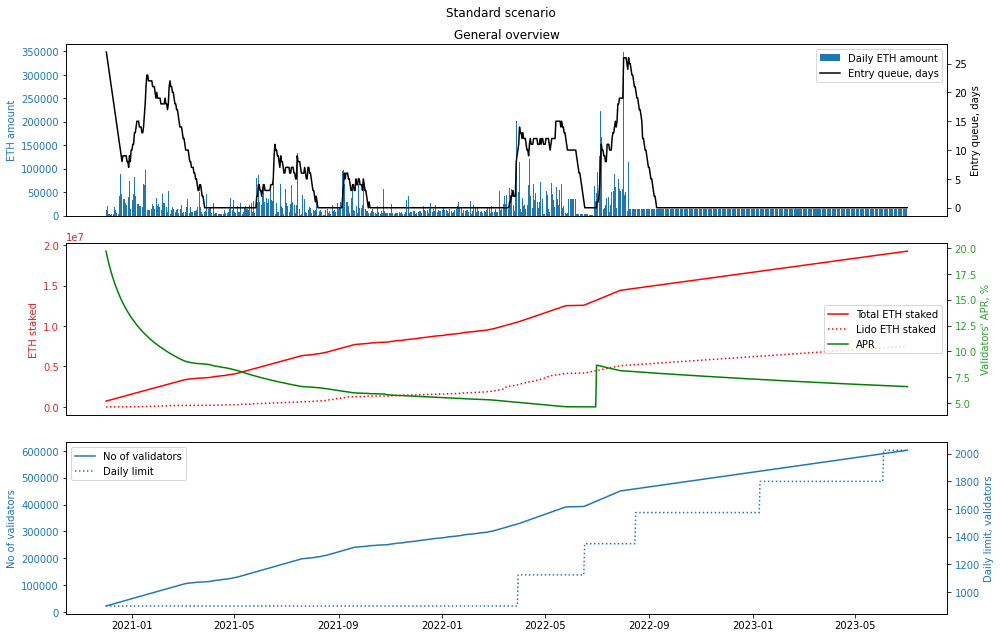

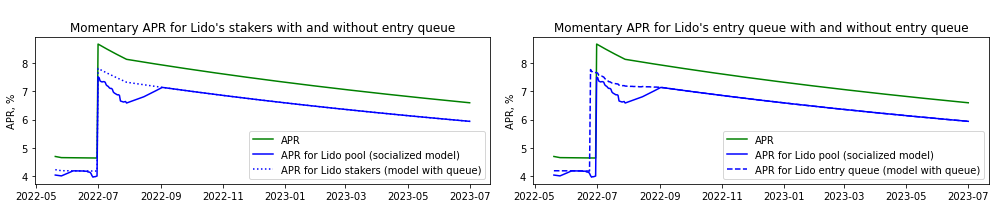

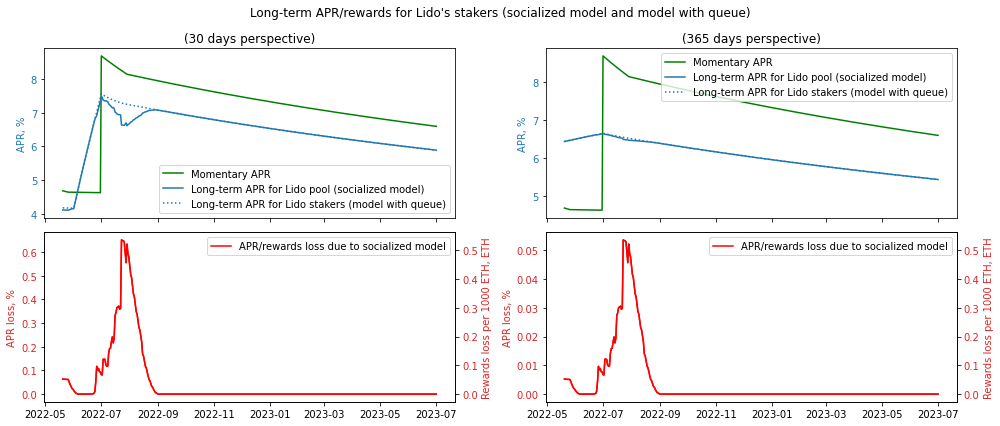

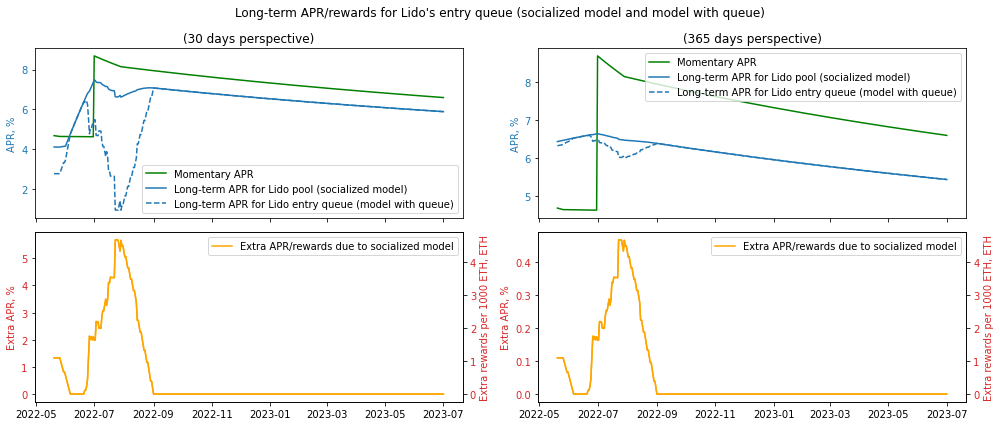

In [25]:
get_lido_charts(modeling_results['2022-07-01']['forecast_using_AR_model']['standard'][0], APR_periods, 'Standard scenario')

,"Max APR loss for Lido stakers, percent points","Max APR loss for Lido stakers, %","Max rewards loss for Lido stakers per 1000 ETH, ETH"
Period,,,
30,1.791792,25.365428,1.472705
365,0.246645,3.877848,2.466450


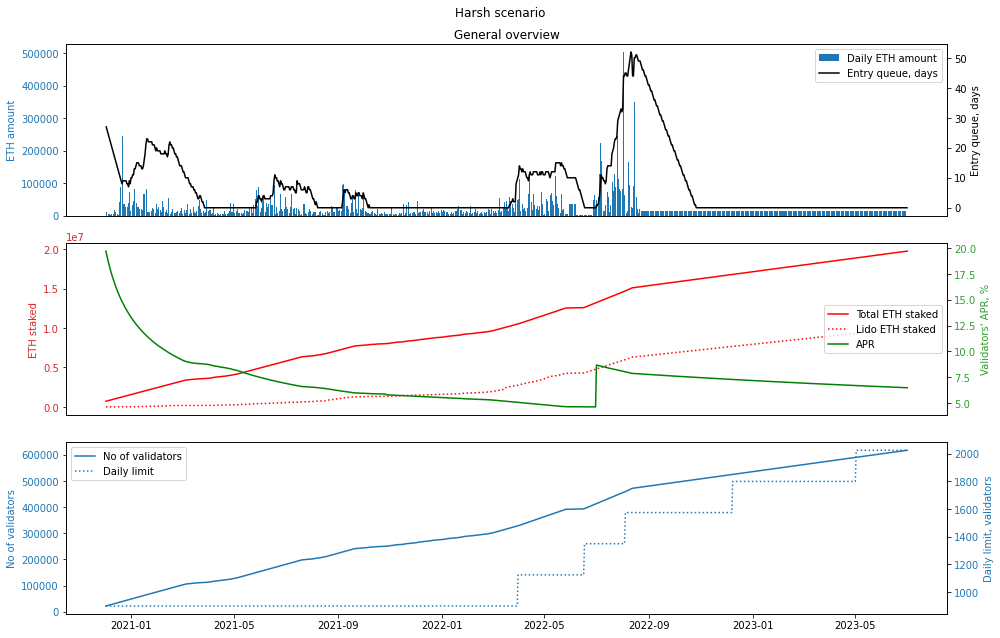

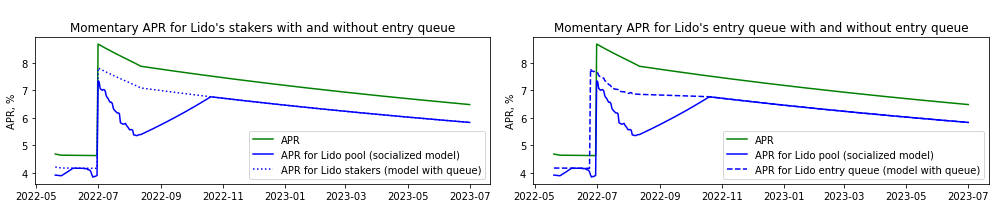

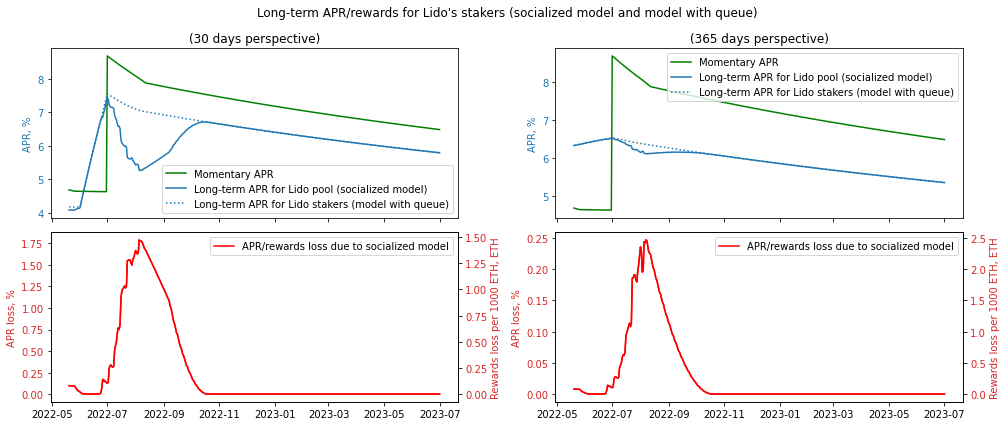

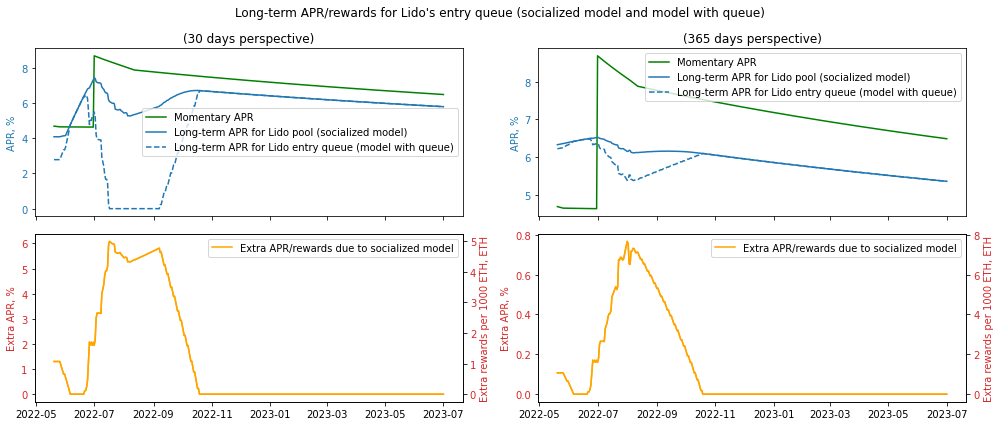

In [26]:
get_lido_charts(modeling_results['2022-07-01']['forecast_using_AR_model']['harsh'][0], APR_periods, 'Harsh scenario')

,"Max APR loss for Lido stakers, percent points","Max APR loss for Lido stakers, %","Max rewards loss for Lido stakers per 1000 ETH, ETH"
Period,,,
30,1.772882,25.167653,1.457163
365,0.243110,3.833829,2.431104


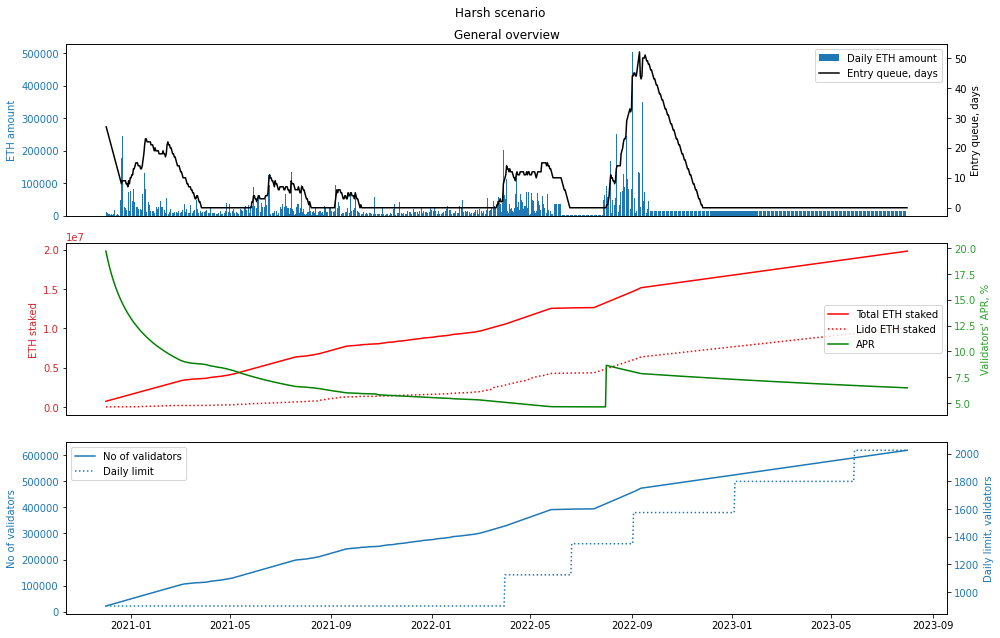

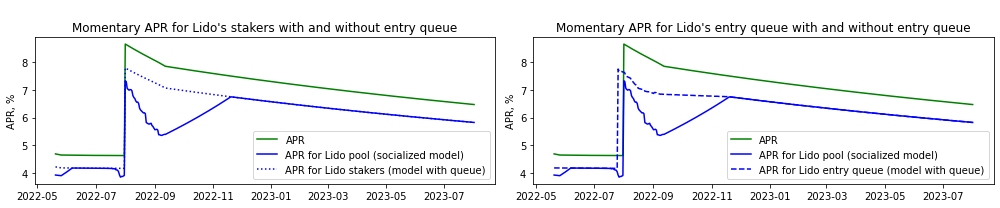

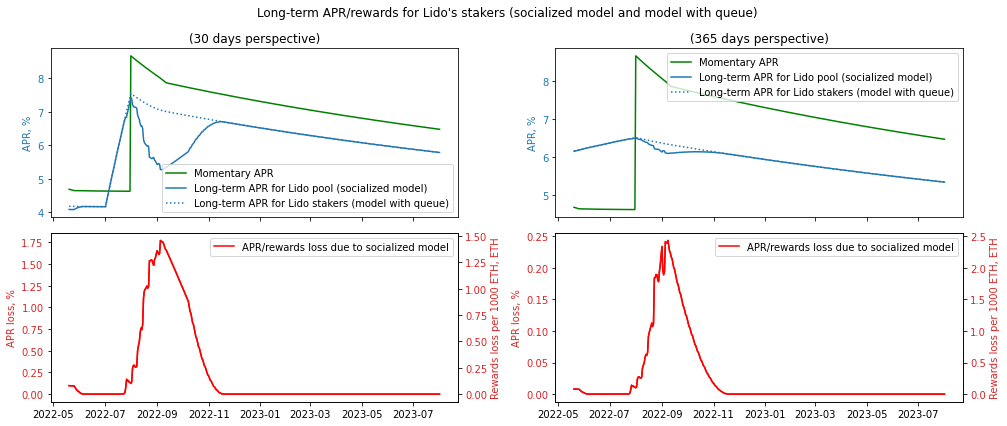

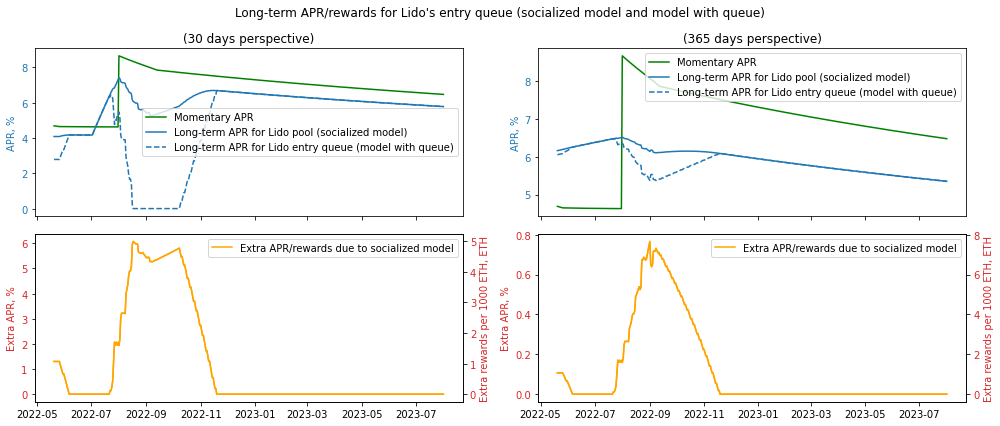

In [27]:
get_lido_charts(modeling_results['2022-08-01']['forecast_using_AR_model']['harsh'][0], APR_periods, 'Harsh scenario')

,"Max APR loss for Lido stakers, percent points","Max APR loss for Lido stakers, %","Max rewards loss for Lido stakers per 1000 ETH, ETH"
Period,,,
30,1.772882,25.167653,1.457163
365,0.243110,3.833829,2.431104


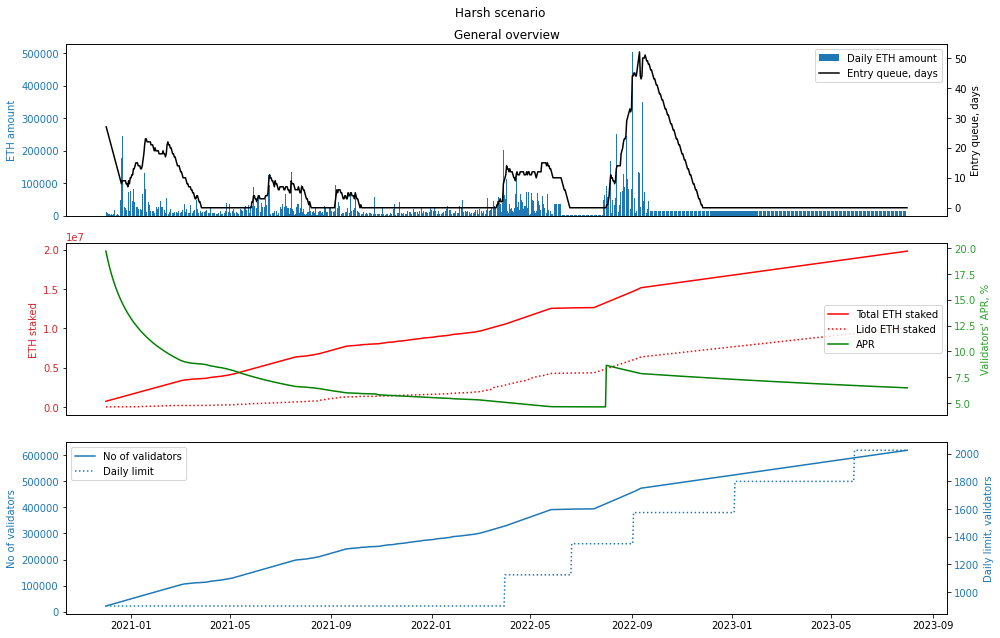

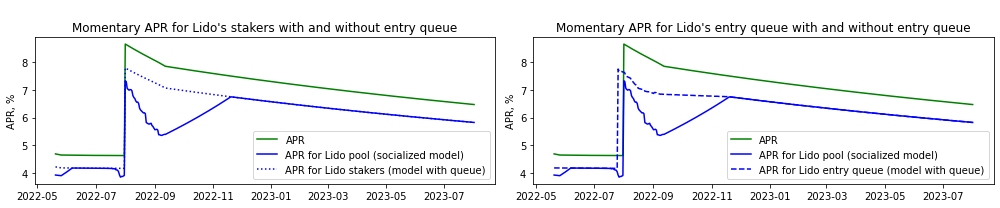

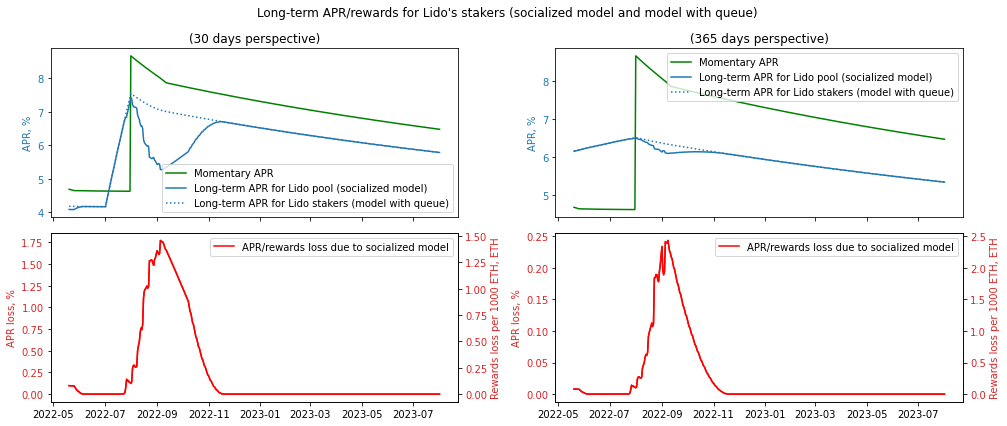

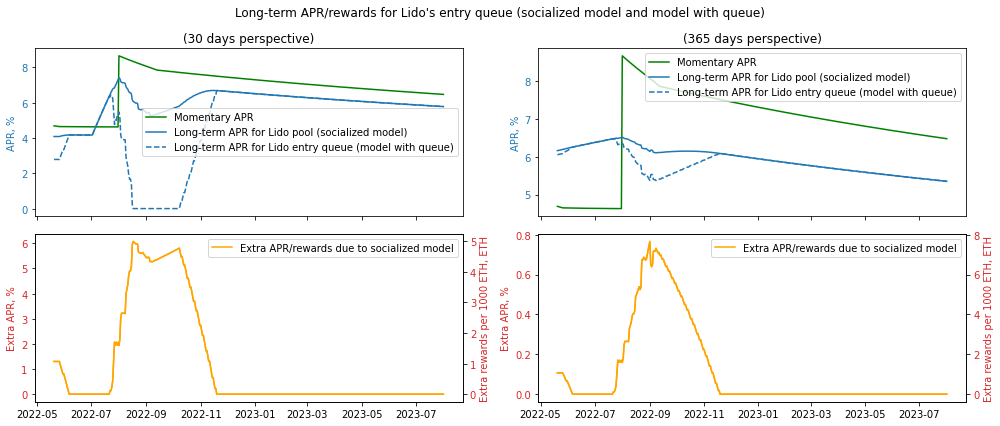

In [28]:
get_lido_charts(modeling_results['2022-08-01']['forecast_using_AR_model']['harsh'][0], APR_periods, 'Harsh scenario')

,"Max APR loss for Lido stakers, percent points","Max APR loss for Lido stakers, %","Max rewards loss for Lido stakers per 1000 ETH, ETH"
Period,,,
30,1.651171,24.299191,1.357127
365,0.237832,3.862036,2.378323


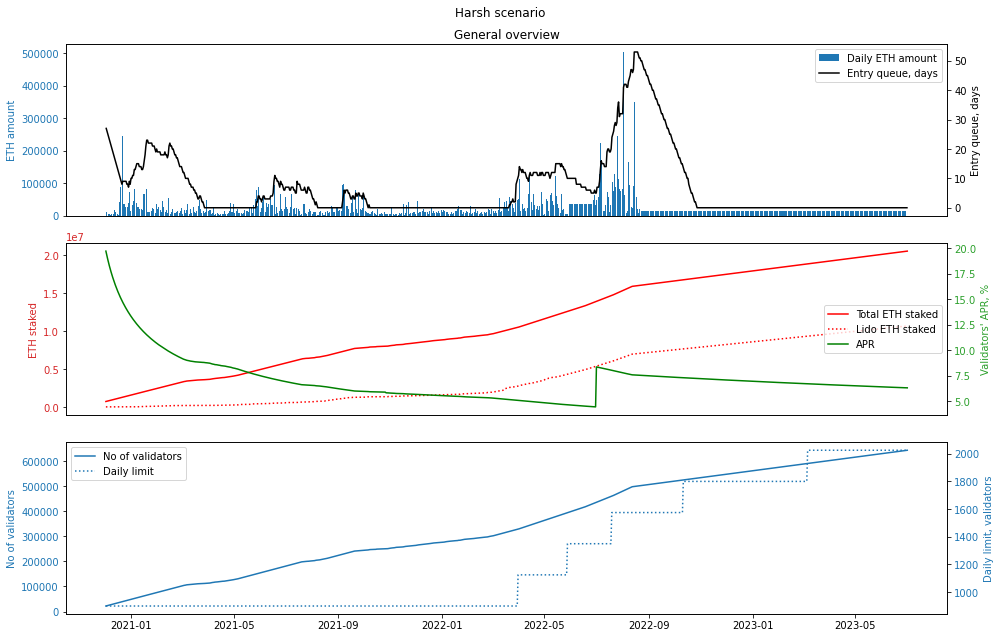

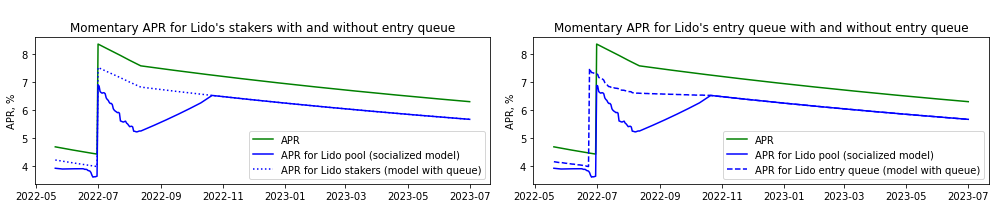

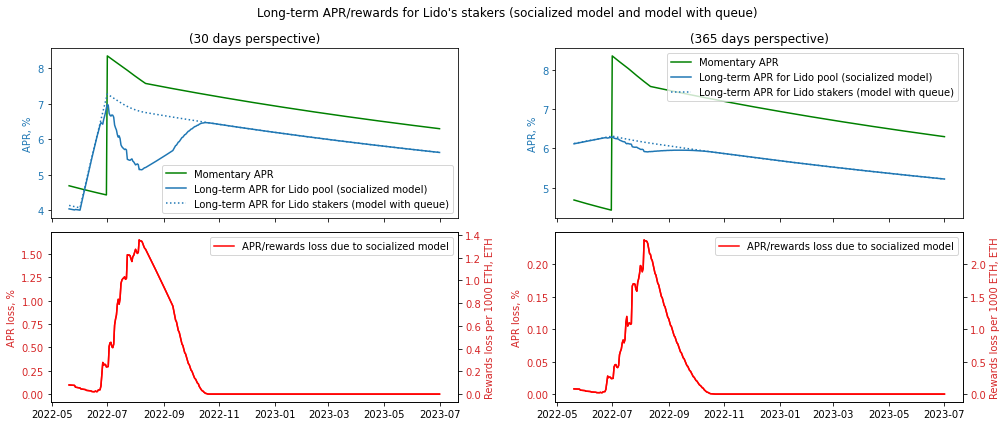

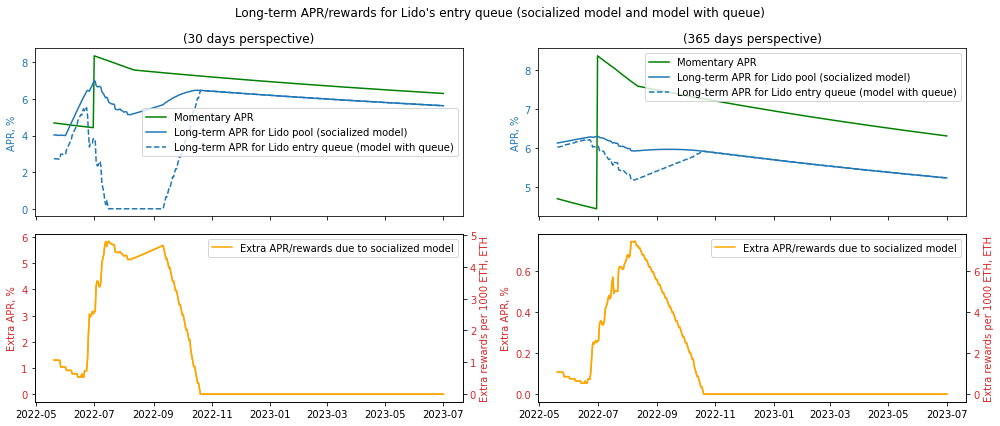

In [29]:
get_lido_charts(modeling_results['2022-07-01']['forecast_based_on_levereged_staking']['harsh'][0], APR_periods, 'Harsh scenario')

,"Max APR loss for Lido stakers, percent points","Max APR loss for Lido stakers, %","Max rewards loss for Lido stakers per 1000 ETH, ETH"
Period,,,
30,1.687992,24.265716,1.387390
365,0.228022,3.632809,2.280217


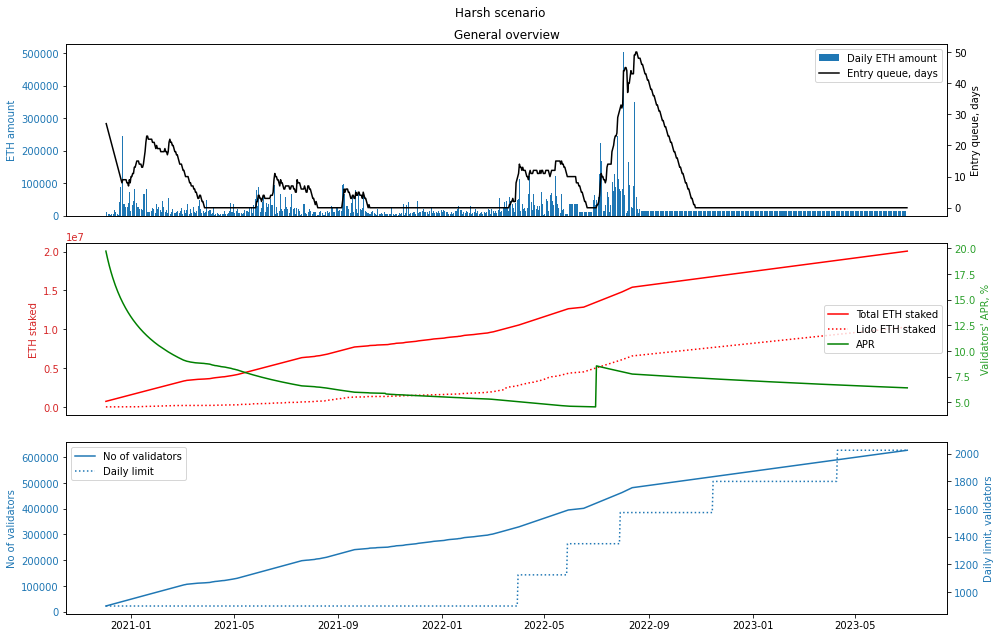

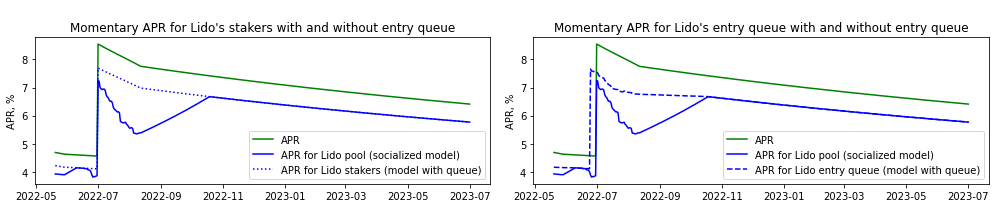

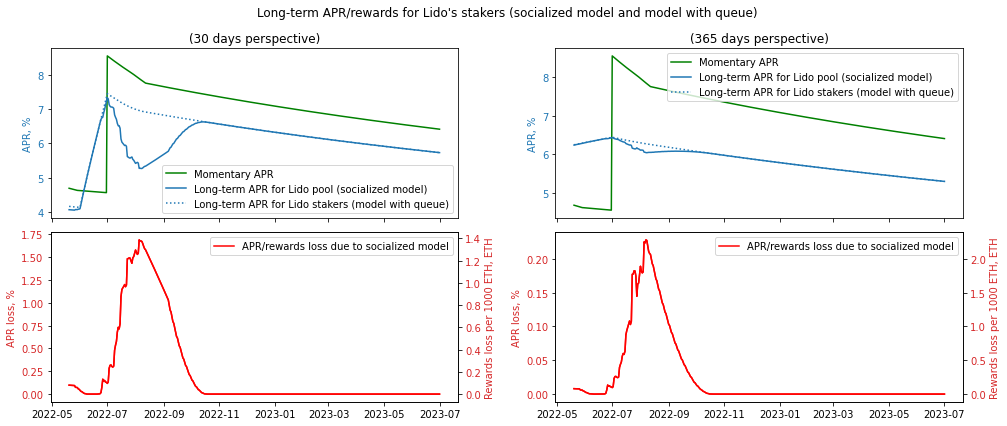

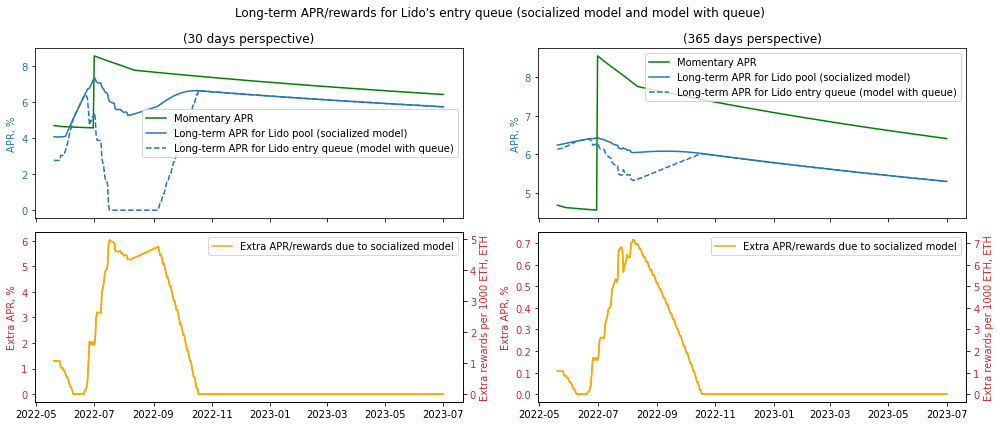

In [30]:
get_lido_charts(modeling_results['2022-07-01']['forecast_using_linear_model']['harsh'][0], APR_periods, 'Harsh scenario')